In [2]:
import pandas as pd
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 가설검정 및 통계 분석 패키지
from scipy import stats

# Scale변환 -> 표준화 회귀계수 산출
## coefficient를 표준화해서 비교해본다.
from sklearn.preprocessing import StandardScaler

from statsmodels.api import Logit

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix


# 주피터 노트북 사용시 그래프 자동 출력 옵션
%matplotlib inline

matplotlib.rc('font', family = "NanumGothic")
plt.rc('font', family = "NanumGothic")
plt.rcParams["font.family"] = 'NanumGothic'

In [3]:
df_raw = pd.read_csv("Data/HMEQ.csv")

### 데이터 전처리

In [4]:
df_raw.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [5]:
## 범주형 변수
df_raw["JOB"].fillna("Other", inplace=True)

## 연속형 변수
# 결측치 있는 모든 열을 평균으로 대체
df_raw.fillna(df_raw.mean(), inplace =True)

In [7]:
df_train, df_test = train_test_split(df_raw,
                                     test_size =0.3, random_state=1234)

print("train data size: {}".format(df_train.shape))
print("Test data size: {}".format(df_test.shape))

train data size: (2623, 13)
Test data size: (1125, 13)


### 3) 모델 및 회귀계수 검토

In [8]:
log_model = Logit.from_formula("""BAD ~ LOAN + MORTDUE + VALUE + C(REASON) + C(JOB) + YOJ + 
                                DEROG+ DELINQ + CLAGE + NINQ + CLNO + DEBTINC""", df_train)
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Thu, 04 Mar 2021   Pseudo R-squ.:                  0.2257
Time:                        17:17:26   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.0942      0.560     -9.100      0.000      -6.191      -3.997

### 4) 예측 및 성능평가

In [10]:
y_pred = log_result.predict(df_test)
y_pred_class = (y_pred > 0.5).astype(int)
y_pred_class.head()

1721    0
822     0
1686    0
789     0
165     0
dtype: int64

In [11]:
print("Accuracy:{0:.3f} \n".format(accuracy_score(df_test["BAD"], y_pred_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["BAD"], y_pred_class)))

# 파이썬에서는 아래와 같이 된다.
#    0 1 
# 0
# 1

Accuracy:0.924 

Confusion Matrix: 
[[1017    4]
 [  81   23]]


## 5) 결론 도출_최종회귀식

<AxesSubplot:>

/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


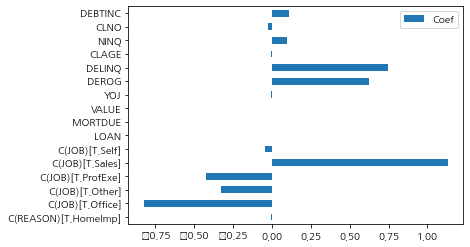

In [12]:
# 설명변수 중요돈
df_logistic_coef = pd.DataFrame({"Coef": log_result.params.values[1:]}, index=log_model.exog_names[1:])
df_logistic_coef.plot.barh(y="Coef")

## 5) 결론도출_표준화 회귀계수
- 데이터 스케일링함으로 변수의 중요도 확인 시 신뢰성 높인다.

In [13]:
# select_dtypes: 특정 타입을 선택/제외해 데이터 추출
df_char = df_raw.select_dtypes(include="object")
df_numeric = df_raw.select_dtypes(exclude="object")

# Data Scailing
scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns=df_numeric.columns)

# 문자데이터 + 숫자데이터
df_scaled = pd.concat([df_numeric_scaled, df_char], axis=1)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,3.140664,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,3.140664,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,-0.318404,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,3.140664,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,-0.318404,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


In [14]:
# BAD 데이터를 0과 1로 변환, 
# np.where(조건, 조건 만족 경우, 조건 비만족 경우)
df_scaled["BAD"] = np.where(df_scaled["BAD"] > 0, 1, 0)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,1,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,0,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,1,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,0,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


In [21]:
# 데이터 분할
df_scaled_train, df_scaled_test = train_test_split(df_scaled,
                                     test_size =0.3, random_state=1234)

In [22]:
# 표준화 회귀 계수
scaled_log_model = Logit.from_formula("""BAD ~ LOAN + MORTDUE + VALUE + C(REASON) + C(JOB) + YOJ + 
                                DEROG+ DELINQ + CLAGE + NINQ + CLNO + DEBTINC""", df_scaled_train)
scaled_log_result = scaled_log_model.fit()
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Thu, 04 Mar 2021   Pseudo R-squ.:                  0.2257
Time:                        17:24:20   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.4815      0.205    -12.111      0.000      -2.883      -2.080

### 중요 설명변수 결론 도출

<AxesSubplot:>

/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


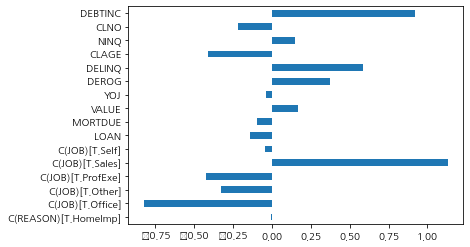

In [23]:
df_log_scaled_coef = pd.DataFrame({"Coef": scaled_log_result.params.values[1:]},
                                  index=scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y="Coef", legend= False)

### 결론도출
- 직업이 Sales이거나, 부채비율(DEBTINC)와 연체된 신용 한도의 수(DELINQ)가 높을 경우 대출 채무 불이행(BAD)일  가능성이 높아진다. 특히 부채비율의 영향이 커짐.